In [79]:
import numpy as np
import pandas as pd
import json
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Companies

The Forbes 2000 list of 2021 can be found at https://www.forbes.com/lists/global2000/#583c53495ac0. Example entries in the ranking are shown below.

In [25]:
companies = pd.read_csv('./logo_scraper/Forbes-2021.csv', encoding="ISO-8859-1")
companies.head()

,Rank,Name,Country,Sales,Profit,Assets,Market Value
0,1,ICBC,China,$190.5 B,$45.8 B,"$4,914.7 B",$249.5 B
1,2,JPMorgan Chase,United States,$136.2 B,$40.4 B,"$3,689.3 B",$464.8 B
2,3,Berkshire Hathaway,United States,$245.5 B,$42.5 B,$873.7 B,$624.4 B
3,4,China Construction Bank,China,$173.5 B,$39.3 B,"$4,301.7 B",$210.4 B
4,5,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,$229.7 B,$49.3 B,$510.3 B,"$1,897.2 B"


# 2. Retrieving logos

Wikipedia displays company logos for most companies that have a Wikipedia entry and provides a good source for scraping. About 2/3rd of the 2000 companies have a Wikipedia entry that can be reached by combining the base URL https://en.wikipedia.org/wiki/ with the "Name" field from our companies data, where any white spaces are replaced with underscores.

### Scraping

The command below scrapes Wikipedia and saves all scraped logos in a subfolder named "full".

In [26]:
# !(cd ./logo_scraper; scrapy crawl logo -O logo_links.json)

### Scraping results

The scraper is not catching all logos, because the URL reconstruction is not correct for all companies, and other companies have a slightly differently structured Wikipedia entry. However, the dataset is sufficiently large for this project.

In [27]:
# read file
with open('./logo_scraper/logo_links.json', 'r') as logofile:
    data = logofile.read()

# parse file
obj = json.loads(data)

print(f"The number of scraped logos is {len(obj)}")

The number of scraped logos is 1323


An example of one of the entries.

In [28]:
obj[0]

{'wiki_url': 'https://en.wikipedia.org/wiki/ICBC',
 'company_name': 'ICBC',
 'wiki_name': 'Industrial and Commercial Bank of China Limited',
 'image_urls': ['https://upload.wikimedia.org/wikipedia/en/thumb/3/33/Industrial_and_Commercial_Bank_of_China_logo.svg/250px-Industrial_and_Commercial_Bank_of_China_logo.svg.png'],
 'images': [{'url': 'https://upload.wikimedia.org/wikipedia/en/thumb/3/33/Industrial_and_Commercial_Bank_of_China_logo.svg/250px-Industrial_and_Commercial_Bank_of_China_logo.svg.png',
   'path': 'full/5c0ae00dfe95ea347da089567f76d242af5f21b9.jpg',
   'checksum': 'a902b15349e88c3ab63a9ca5bd24b327',
   'status': 'downloaded'}]}

Example images of the scraped logos.

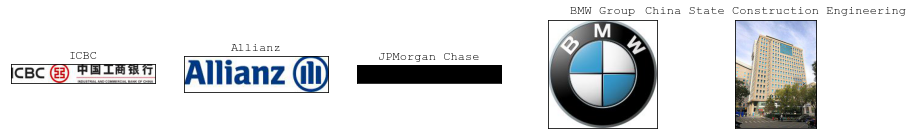

In [29]:
fig, axs = plt.subplots(figsize=[15, 2], nrows=1, ncols=5)
axs = np.ravel(axs)
obj_show = [obj[0], obj[18], obj[7], obj[49], obj[84]]
for i, logo in enumerate(obj_show):
    path = os.path.join("./logo_scraper", logo['images'][0]['path'])
    axs[i].imshow(Image.open(path))
    axs[i].set_title(logo['company_name'], fontname="Courier New")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

Clearly there are some erroneous images that are (nearly) all black or show a company building, not the logo. These images are removed manually before further processing.

In [48]:
to_drop_black = [
    "JPMorgan Chase", "Sony", "BlackRock", "Volvo Group",
    "Panasonic", "Kering", "Ericsson", "Macquarie Group",
    "Norfolk Southern", "BASF", "Activision Blizzard", "Adidas",
    "Nissan Motor", "Advanced Micro Devices", "Renault", "BOE Technology Group",
    "Simon Property Group", "Assa Abloy", "Coal India", "T Rowe Price",
    "Marriott International", "L Brands", "Western Digital", "DaVita",
    "Autodesk", "Arrow Electronics", "Agilent Technologies", "Asustek Computer",
    "IDEXX Laboratories", "Zebra Technologies", "Bancolombia", "First Quantum Minerals",
    "Citrix Systems", "CrowdStrike", "DocuSign", "Palantir Technologies",
    "AECOM Technology", "CoStar Group", "JD Sports Fashion", "Marvell Technology Group",
    "Frost Bankers", "Nanto Bank", "Toll Brothers", "Unity Software"
]

to_drop_building = [
    "China State Construction Engineering", "China Railway Construction", "Westinghouse Air Brake Technologies",
    "Nomura Research Institute", "Hotai Motor", "Taiwan Cement", "Chang Hwa Bank",
    "China Railway Signal & Communication", "DGB Financial Group"
]

to_drop_all = to_drop_black
to_drop_all.append(to_drop_building)

In [51]:
obj_cleaned = [item for item in obj if item['company_name'] not in to_drop_all]
print(f"The number of useable logos is {len(obj_cleaned)}")

The number of useable logos is 1279


Some logos are quite a bit larger than others. Currently, the size distribution is as follows.

In [58]:
sz = [Image.open(os.path.join("./logo_scraper", logo['images'][0]['path'])).size for logo in obj_cleaned]
sz_list = np.array([list(s) for s in sz])

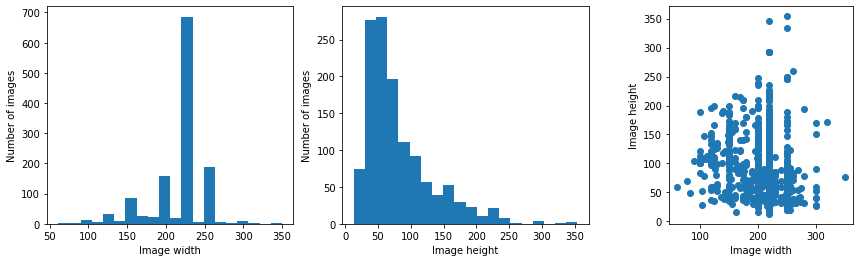

In [74]:
fig, axs = plt.subplots(figsize=[15, 4], nrows=1, ncols=3)

axs[0].hist(sz_list[:, 0], bins=20)
axs[0].set_xlabel('Image width')
axs[0].set_ylabel('Number of images')

axs[1].hist(sz_list[:, 1], bins=20)
axs[1].set_xlabel('Image height')
axs[1].set_ylabel('Number of images')

axs[2].scatter(sz_list[:, 0], sz_list[:, 1])
axs[2].set_aspect(aspect="equal")
axs[2].set_xlabel('Image width')
axs[2].set_ylabel('Image height')

plt.show()

All logos will be resized to 128x128 pizels, where aspect ratio will be conserved and empty pace will be filled in with white pixels.

For example:

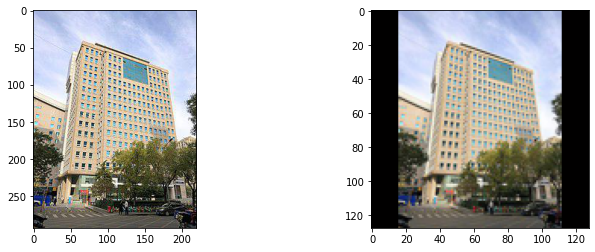

In [109]:
new_size = [128, 128]

path = os.path.join("./logo_scraper", logo['images'][0]['path'])

img1 = Image.open(path)

img2 = ImageOps.contain(img1, new_size)
expand_by = tuple(np.array((new_size - np.array(img2.size)) / 2).astype(int))
img2 = ImageOps.expand(image=img2, border=expand_by, fill=1)

fig, axs = plt.subplots(figsize=[12, 4], nrows=1, ncols=2)
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()